# Pipeline for High-z Radio Galaxies 02: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

***

## Reading data

We import our data using the `pandas` package.

In [3]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [4]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag',\
                     'W2mag', 'spCl', 'FUVmag', 'NUVmag', 'num_imputed'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [5]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [6]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [7]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [8]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 83409 elements,
28251 of them are marked as AGN, and 55158 are identified as galaxies.


---

## Possible correlations

In [9]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

Create target

$0$ for galaxies and $1$ for AGN

In [10]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [11]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str'])

## Split data: Test, Train, Validation

In [12]:
target_feat = 'class'

In [13]:
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])

print('Shape of used data in HETDEX')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
--------------------------------------------------
Full confirmed dataset size:        (83409, 80)
Data for Modeling (Train and Test): (66727, 80)
Training data:                      (46708, 80)
Testing data:                       (20019, 80)
validation data:                    (16682, 80)
--------------------------------------------------



Save indices of sources in validation sub-set for future steps.

In [14]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [15]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [16]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [17]:
rsd_vals

K_W3        1316.463046
z_y          222.813278
i_z          211.438786
class        139.729050
i_y          123.281109
r_i          113.100182
y_W2         112.056846
g_r           96.045245
r_z           88.503172
y_W1          87.222912
z_W2          85.550365
r_y           79.287827
g_i           74.159637
z_W1          73.260473
g_z           69.627585
i_W2          68.403402
H_W3          67.093097
g_y           66.576281
i_W1          63.665291
r_W1          58.382172
r_W2          55.954758
g_W1          51.957239
J_W3          49.779707
y_J           47.047555
g_W2          46.142799
W1_W3         43.490649
y_H           42.508673
z_J           42.017880
J_H           41.547040
i_J           38.644800
z_H           38.292910
r_J           37.311930
y_K           37.136689
i_H           35.475580
y_W3          35.297026
r_H           34.765387
g_J           34.321636
z_K           34.051694
H_K           33.241848
W2_W3         32.481121
g_H           32.441469
z_W3          32

In [18]:
correlation = norm_train_test_df.corr()

In [19]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [20]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [21]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [22]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [23]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'g_K',
 'gmag',
 'r_K',
 'rmag',
 'i_K',
 'y_K',
 'z_K',
 'imag',
 'ymag',
 'zmag',
 'W1mproPM',
 'H_W1',
 'W2mproPM',
 'K_W1',
 'g_W4',
 'J_W3',
 'H_W2',
 'r_W4',
 'K_W2',
 'Jmag',
 'i_W4',
 'y_W4',
 'z_W4',
 'J_W4',
 'g_W2',
 'g_W3',
 'W1_W4',
 'r_W3',
 'r_W2',
 'y_W3',
 'W2_W4',
 'i_W3',
 'z_W3',
 'W3mag',
 'g_y',
 'Kmag',
 'H_W3',
 'g_z',
 'J_K',
 'z_J',
 'i_W1',
 'Hmag',
 'z_W1',
 'y_W1',
 'W2_W3',
 'r_J',
 'g_W1',
 'W3_W4',
 'i_J',
 'z_W2',
 'K_W4',
 'H_W4',
 'r_y',
 'i_W2',
 'g_i',
 'band_num']

In [24]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [25]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [26]:
corr_discard = norm_train_test_discard.corr()

In [27]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

W4mag  W4mag    1.000000
class  W1_W2    0.789702
r_i    r_z      0.707557
y_J    y_W2     0.684981
g_J    r_W1     0.677932
r_W1   r_z      0.652444
       r_i      0.617072
K_W3   W4mag    0.592406
W1_W2  W1_W3    0.581923
i_z    i_y      0.574151
i_y    z_y      0.562290
W1_W3  y_J      0.558754
g_J    r_z      0.538505
y_J    g_J      0.536845
r_W1   W1_W2    0.516092
dtype: float64

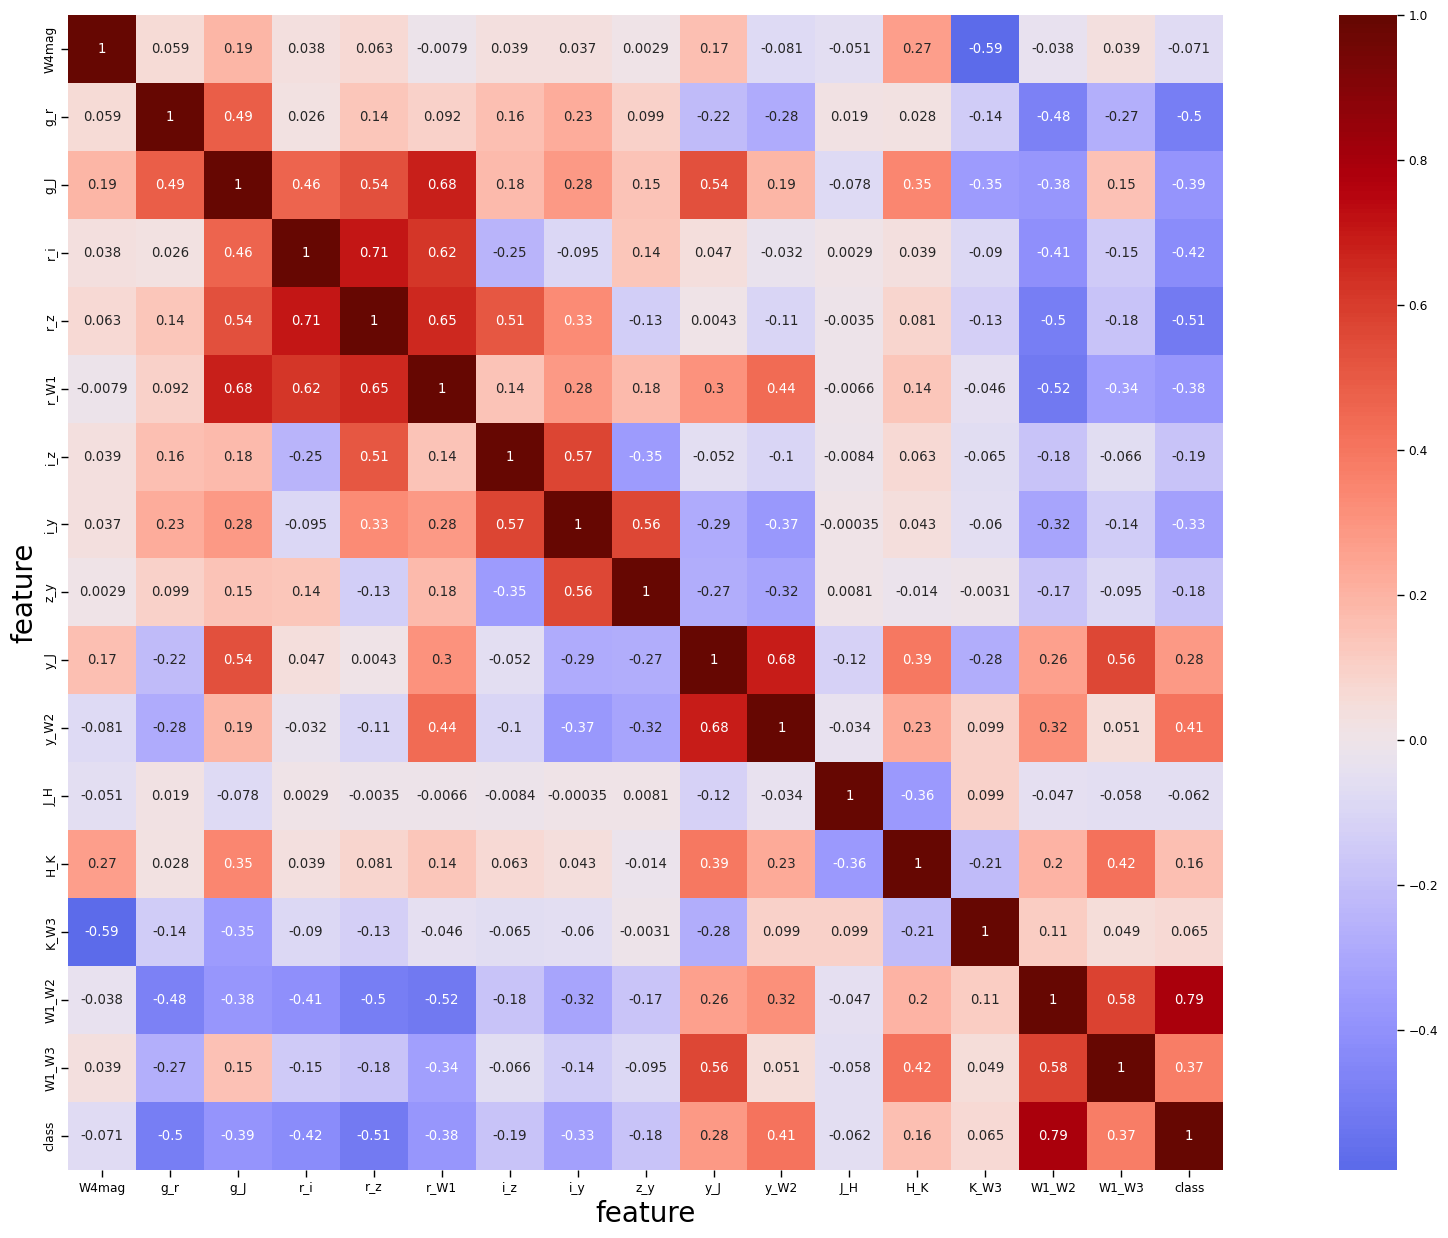

In [28]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [29]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [30]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [31]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
W1_W2  class    0.725646
g_r    class    0.575152
r_z    class    0.525163
r_i    class    0.518954
class  W1_W2    0.483988
r_z    r_i      0.374167
r_i    r_z      0.367000
J_H    H_K      0.348840
i_y    class    0.280602
g_J    class    0.265828
y_W2   class    0.254440
class  r_z      0.250037
       g_r      0.242430
r_W1   class    0.236589
W1_W3  class    0.234030
g_r    g_J      0.228937
i_z    class    0.221771
class  r_i      0.215503
r_z    r_W1     0.204538
dtype: float64

In [32]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [33]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [34]:
list_drop_pps = []

In [35]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [36]:
list_drop_pps

[]

In [37]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [38]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=gv.seed)

In [39]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.725646,classification,True,weighted F1,0.544,0.874894,DecisionTreeClassifier()
1,g_r,class,0.575152,classification,True,weighted F1,0.544,0.806269,DecisionTreeClassifier()
2,r_z,class,0.525163,classification,True,weighted F1,0.544,0.783474,DecisionTreeClassifier()
3,r_i,class,0.518954,classification,True,weighted F1,0.544,0.780643,DecisionTreeClassifier()
4,i_y,class,0.280602,classification,True,weighted F1,0.544,0.671954,DecisionTreeClassifier()
5,g_J,class,0.265828,classification,True,weighted F1,0.544,0.665218,DecisionTreeClassifier()
6,y_W2,class,0.254440,classification,True,weighted F1,0.544,0.660025,DecisionTreeClassifier()
7,r_W1,class,0.236589,classification,True,weighted F1,0.544,0.651885,DecisionTreeClassifier()
8,W1_W3,class,0.234030,classification,True,weighted F1,0.544,0.650718,DecisionTreeClassifier()
9,i_z,class,0.221771,classification,True,weighted F1,0.544,0.645128,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [57]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [58]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [59]:
exp_AGN = pyc.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(66727, 80)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [60]:
pyc.get_config('X').columns

Index(['W4mag', 'g_r', 'g_J', 'r_i', 'r_z', 'r_W1', 'i_z', 'i_y', 'z_y', 'y_J',
       'y_W2', 'J_H', 'H_K', 'K_W3', 'W1_W2', 'W1_W3'],
      dtype='object')

In [61]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [62]:
metric_to_optimize   = 'Recall'

In [63]:
final_selection_clf   = ['catboost', 'xgboost', 'et', 'gbc', 'rf', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9566,0.9872,0.9245,0.9461,0.9352,0.9025,0.9027,1.7280
xgboost,Extreme Gradient Boosting,0.9548,0.9861,0.9214,0.9439,0.9325,0.8986,0.8987,9.0940
et,Extra Trees Classifier,0.9543,0.9847,0.9185,0.9450,0.9316,0.8973,0.8975,0.2340
gbc,Gradient Boosting Classifier,0.9528,0.9847,0.9170,0.9422,0.9294,0.8940,0.8942,1.8560
rf,Random Forest Classifier,0.9545,0.9849,0.9169,0.9470,0.9317,0.8976,0.8979,0.8620
dt,Decision Tree Classifier,0.9276,0.9216,0.8939,0.8926,0.8932,0.8385,0.8385,0.3190
dummy,Dummy Classifier,0.6613,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [64]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0],\
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9563,0.9884,0.9273,0.9428,0.9350,0.9021,0.9022
1,0.9544,0.9856,0.9229,0.9413,0.9320,0.8977,0.8978
2,0.9572,0.9885,0.9241,0.9481,0.9360,0.9038,0.9040
3,0.9555,0.9859,0.9229,0.9444,0.9335,0.9000,0.9002
4,0.9499,0.9844,0.9121,0.9382,0.9250,0.8874,0.8876
5,0.9613,0.9908,0.9298,0.9546,0.9420,0.9129,0.9131
6,0.9585,0.9885,0.9298,0.9466,0.9381,0.9069,0.9070
7,0.9535,0.9836,0.9115,0.9493,0.9300,0.8953,0.8957
8,0.9582,0.9870,0.9286,0.9471,0.9378,0.9063,0.9064


In [65]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping=True, optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9553,0.9893,0.9254,0.9415,0.9334,0.8997,0.8998
1,0.9542,0.9856,0.9197,0.9436,0.9315,0.8971,0.8973
2,0.9580,0.9885,0.9241,0.9506,0.9372,0.9057,0.9059
3,0.9542,0.9862,0.9204,0.9430,0.9315,0.8971,0.8973
4,0.9512,0.9842,0.9115,0.9425,0.9267,0.8902,0.8904
5,0.9617,0.9906,0.9286,0.9570,0.9426,0.9138,0.9141
6,0.9570,0.9880,0.9286,0.9435,0.9360,0.9036,0.9036
7,0.9525,0.9840,0.9096,0.9480,0.9284,0.8928,0.8933
8,0.9570,0.9879,0.9260,0.9458,0.9358,0.9034,0.9035


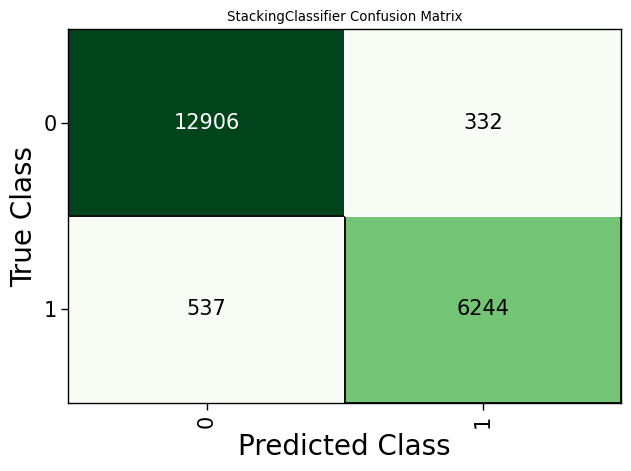

In [66]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

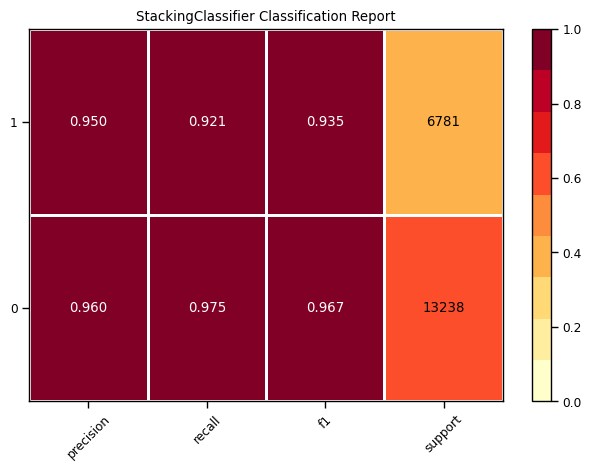

In [67]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

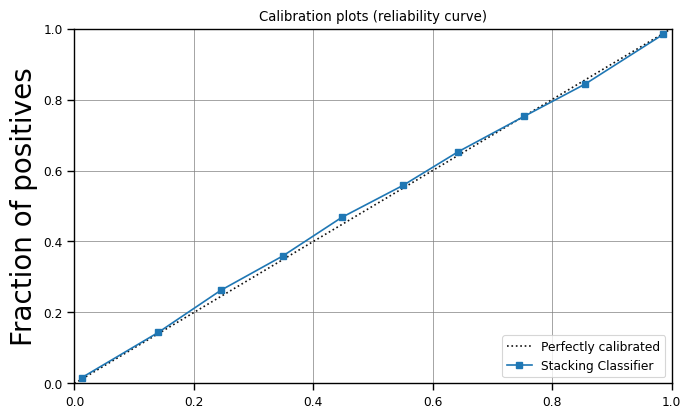

In [68]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

In [73]:
# pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='feature_all')

In [74]:
pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,236
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [75]:
plt.rcParams.update(plt.rcParamsDefault)

In [76]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9566,0.9874,0.9208,0.9495,0.9349,0.9024,0.9026


,Score_0,Score_1
count,20019.000000,20019.000000
mean,0.662413,0.337587
std,0.436127,0.436127
min,0.003000,0.003300
25%,0.046900,0.007300
50%,0.978000,0.022000
75%,0.992700,0.953100
max,0.996700,0.997000


In [77]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9566,0.9874,0.9208,0.9495,0.9349,0.9024,0.9026


In [78]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [79]:
pyc.predict_model(final_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9929,0.9998,0.9854,0.9936,0.9895,0.9841,0.9842


,Score_0,Score_1
count,20019.000000,20019.000000
mean,0.662432,0.337568
std,0.445368,0.445368
min,0.002700,0.002000
25%,0.033050,0.006100
50%,0.983000,0.017000
75%,0.993900,0.966950
max,0.998000,0.997300


In [80]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, gv.models_path + gv.AGN_gal_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [40]:
if load_model_flag:
    final_AGN_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [41]:
base_models_names = gf.get_base_estimators_names(final_AGN_clf)
base_models       = gf.get_base_estimators_models(final_AGN_clf)

In [42]:
print('Running data pre-processing:\n')
extended_data_AGN_df = gf.preprocess_data(final_AGN_clf, validation_df, base_models_names)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [43]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_AGN_clf, extended_data_AGN_df)

In [44]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_AGN_df)

In [45]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [46]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for et...
Calculating for gbc...
Calculating for rf...


xgboost                 et                gbc                 rf           
   Feature Importance Feature Importance Feature Importance Feature Importance
0    W1_W2    57.1925   W1_W2    36.7164   W1_W2    76.5280   W1_W2    29.9468
1      r_z    14.0645     g_J     7.9522     r_z     9.5479     g_r    12.6937
2     y_W2     5.5225    y_W2     7.9461    y_W2     5.1139     r_z    12.3672
3    W1_W3     3.2774     g_r     7.4842     g_r     2.7518     r_i    11.7598
4      g_J     2.7987     r_z     6.8763   W1_W3     2.0310    y_W2     6.8381
5    W4mag     2.7193    r_W1     6.1847     g_J     1.9435    r_W1     4.8678
6      H_K     2.4923     r_i     5.8132     r_i     0.7357     i_y     4.7609
7      g_r     2.2694   W1_W3     5.4368   W4mag     0.4773     g_J     4.2951
8     K_W3     1.7277     y_J     4.8309    K_W3     0.2625   W1_W3     2.6615
9      r_i     1.5034     i_y     2.8582     H_K     0.2051     i_z     2.6338
10    r_W1     1.2512     i_z     2.3462     y_J     0.1455     y_J     2.3070
11     y_J     1.2431     z_y     1.8143    r_W1     0.1243     z_y     1.5602
12     i_y     1.0696    K_W3     1.2834     i_z     0.0749     H_K     1.4525
13     J_H     1.0221     H_K     0.8514     i_y     0.0313    K_W3     0.9219
14     i_z     0.9923   W4mag     0.8213     J_H     0.0225     J_H     0.5047
15     z_y     0.8540     J_H     0.7843     z_y     0.0048   W4mag     0.4291

In [47]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
with pd.option_context('display.float_format', '{:.4e}'.format):
    display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,rf,4.6396e+01
1,xgboost,1.5653e+01
2,gbc,1.4952e+01
3,et,1.3427e+01
4,W1_W2,2.5148e+00
5,W1_W3,1.8044e+00
6,r_W1,9.6901e-01
7,K_W3,7.8856e-01
8,H_K,7.0458e-01
9,g_r,6.4638e-01


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W2	50.096
r_z	10.714
y_W2	6.355
g_r	6.300
r_i	4.953
g_J	4.247
W1_W3	3.352
r_W1	3.107
i_y	2.180
y_J	2.132
i_z	1.512
H_K	1.250
W4mag	1.112
z_y	1.058
K_W3	1.049
J_H	0.583


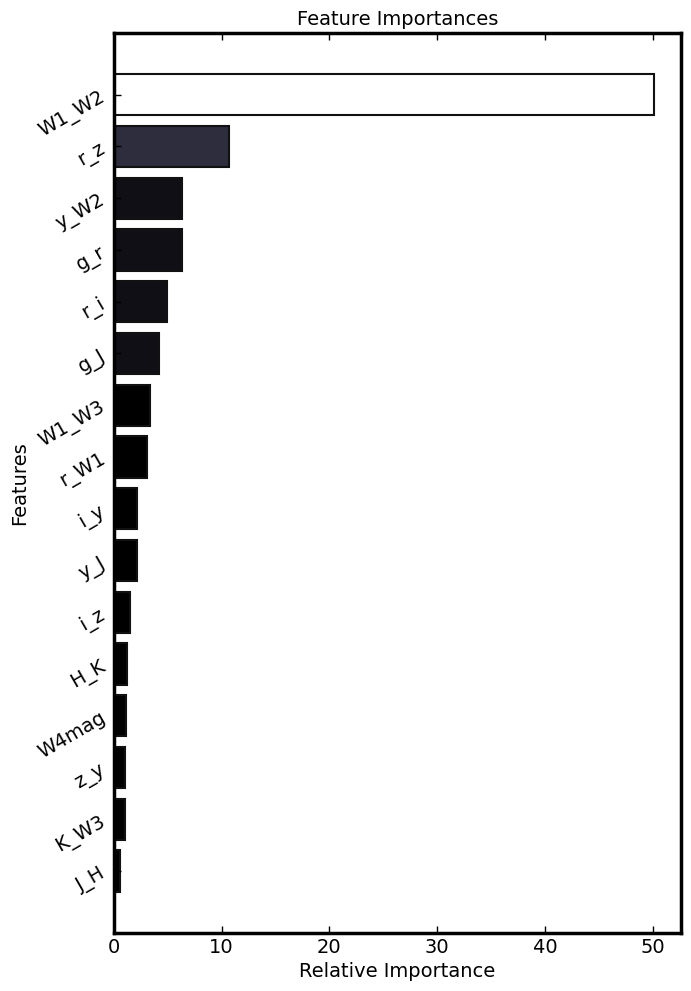

In [48]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [49]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 46,708
Size of test set is  20,019


#### Calculate optimal threshold for classification

In [50]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,      probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,       probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

#### Naive threshold metrics.

In [51]:
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])

In [52]:
MCC_val_naive           = gf.MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = gf.ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = gf.F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = gf.Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = gf.MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = gf.ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = gf.F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = gf.Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = gf.MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = gf.ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = gf.F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = gf.Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = gf.MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = gf.ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = gf.F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = gf.Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [53]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [54]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.9888,0.9831,0.9843,0.9924
Test,0.9895,0.9842,0.9854,0.9929
Train+Test,0.9890,0.9834,0.9846,0.9926
Validation,0.9379,0.9068,0.9276,0.9584


#### Calibration curve

In [55]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

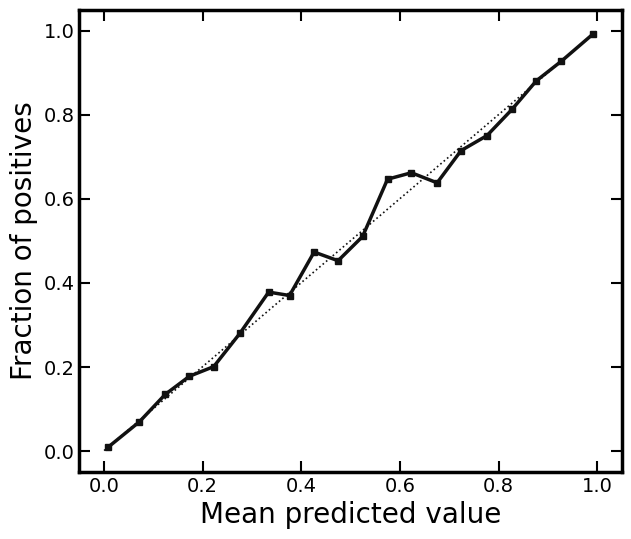

In [56]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

Calculate ROC AUC values and plots.

In [57]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [58]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99983
Area under the curve (ROC) for test       = 0.99983
Area under the curve (ROC) for train+test = 0.99983
Area under the curve (ROC) for validation = 0.98954


In [59]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

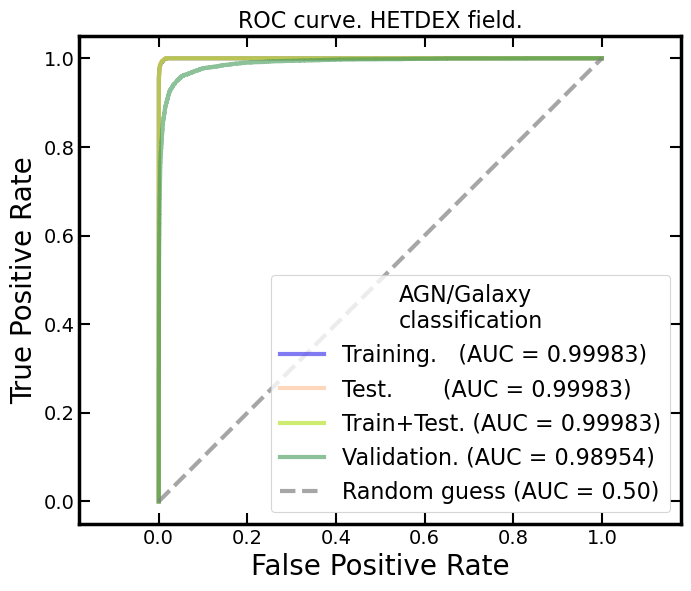

In [60]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [61]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [62]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training   = 0.34319
Optimal threshold from area under the curve (ROC) for test       = 0.35926
Optimal threshold from area under the curve (ROC) for train+test = 0.36690
Optimal threshold from area under the curve (ROC) for validation = 0.27284


##### Precision-Recall curve

In [63]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [64]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

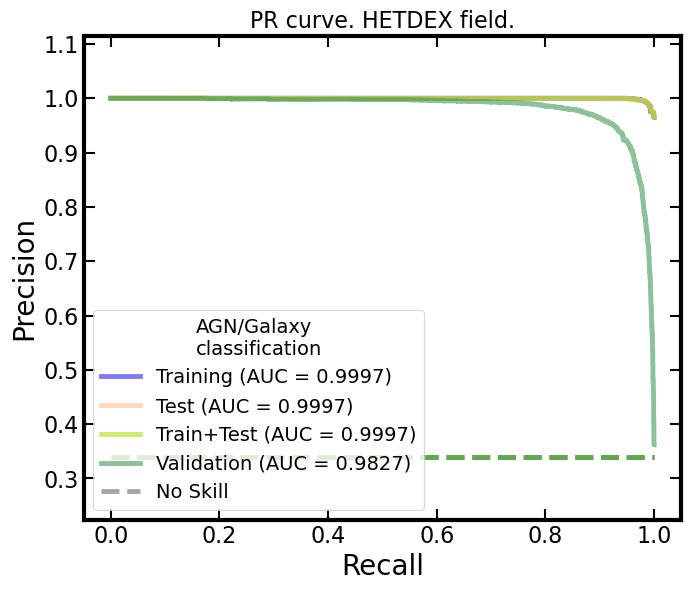

In [65]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [66]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [67]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [68]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training   = 0.44961
Optimal threshold from Precision-Recall curve for test       = 0.46146
Optimal threshold from Precision-Recall curve for train+test = 0.44535
Optimal threshold from Precision-Recall curve for validation = 0.47279


---

In [69]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.44535

In [70]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,      probability_threshold=AGN_pred_threshold, raw_score=True)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,       probability_threshold=AGN_pred_threshold, raw_score=True)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrices.

In [71]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [72]:
MCC_gal_AGN_train         = gf.MCC_from_CM(cm_mat_train)
ACC_gal_AGN_train         = gf.ACC_from_CM(cm_mat_train)
F1_gal_AGN_train          = gf.F1_from_CM(cm_mat_train)
Recall_gal_AGN_train      = gf.Recall_from_CM(cm_mat_train)

MCC_gal_AGN_test          = gf.MCC_from_CM(cm_mat_test)
ACC_gal_AGN_test          = gf.ACC_from_CM(cm_mat_test)
F1_gal_AGN_test           = gf.F1_from_CM(cm_mat_test)
Recall_gal_AGN_test       = gf.Recall_from_CM(cm_mat_test)

MCC_gal_AGN_train_test    = gf.MCC_from_CM(cm_mat_train_test)
ACC_gal_AGN_train_test    = gf.ACC_from_CM(cm_mat_train_test)
F1_gal_AGN_train_test     = gf.F1_from_CM(cm_mat_train_test)
Recall_gal_AGN_train_test = gf.Recall_from_CM(cm_mat_train_test)

MCC_gal_AGN_val           = gf.MCC_from_CM(cm_mat_val)
ACC_gal_AGN_val           = gf.ACC_from_CM(cm_mat_val)
F1_gal_AGN_val            = gf.F1_from_CM(cm_mat_val)
Recall_gal_AGN_val        = gf.Recall_from_CM(cm_mat_val)

final_scores_array      = np.array([[F1_gal_AGN_train,      MCC_gal_AGN_train,      Recall_gal_AGN_train,      ACC_gal_AGN_train],\
                                    [F1_gal_AGN_test,       MCC_gal_AGN_test,       Recall_gal_AGN_test,       ACC_gal_AGN_test],\
                                    [F1_gal_AGN_train_test, MCC_gal_AGN_train_test, Recall_gal_AGN_train_test, ACC_gal_AGN_train_test],\
                                    [F1_gal_AGN_val,        MCC_gal_AGN_val,        Recall_gal_AGN_val,        ACC_gal_AGN_val]])

In [73]:
final_scores_df = pd.DataFrame(data=final_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [74]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df)

,F1,MCC,Recall,ACC
Train,0.9893,0.9839,0.9887,0.9928
Test,0.9900,0.9848,0.9898,0.9932
Train+Test,0.9895,0.9842,0.9891,0.9929
Validation,0.9375,0.9058,0.9336,0.9579


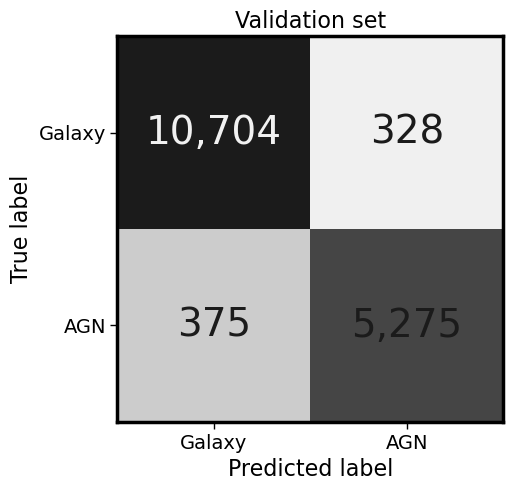

In [75]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

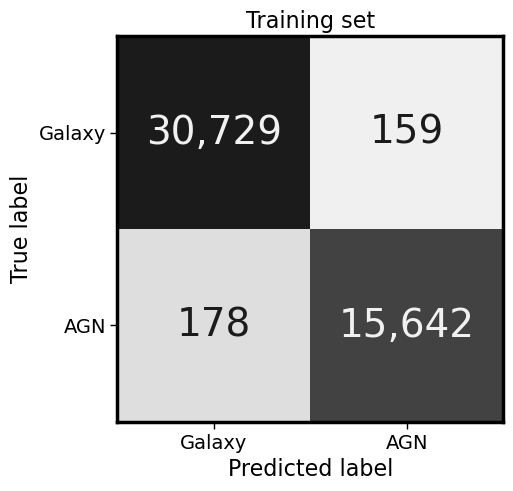

In [76]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

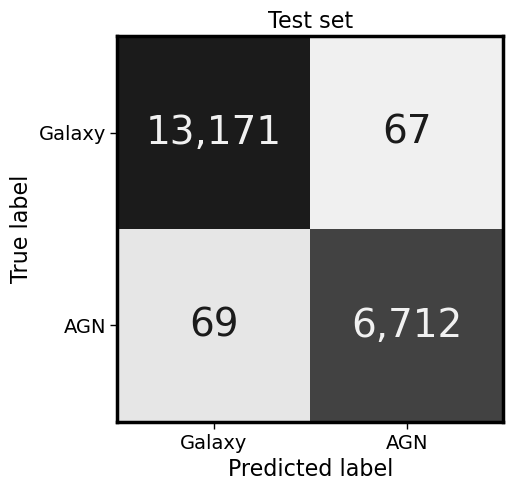

In [77]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

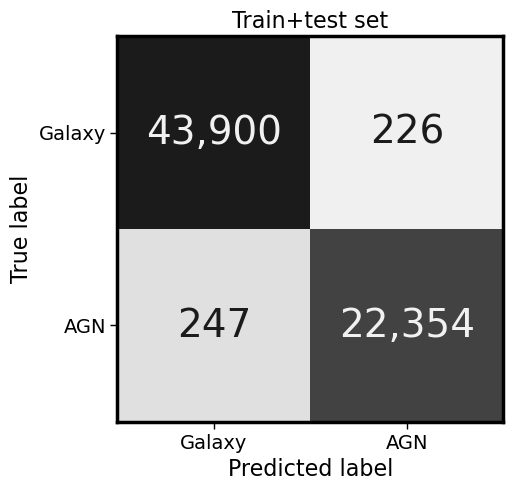

In [78]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [79]:
print('Running data pre-processing for calibration (train+test):\n')
extended_train_test_df = gf.preprocess_data(final_AGN_clf, train_test_df, base_models_names)
initial_cols           = extended_train_test_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [80]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    calibrated_final_AGN_clf = CalibratedClassifierCV(base_estimator=final_AGN_clf.named_steps['trained_model'], cv='prefit')
    calibrated_final_AGN_clf.fit(train_test_df.loc[:, gf.get_final_column_names(final_AGN_clf, train_test_df)], train_test_df.loc[:, target_feat])
else:
    calibrated_final_AGN_clf = CalibratedClassifierCV(base_estimator=final_AGN_clf, cv='prefit')
    calibrated_final_AGN_clf.fit(train_test_df.loc[:, pyc.get_config('X').columns], train_test_df.loc[:, target_feat])

In [81]:
pred_cal_prob_train      = calibrated_final_AGN_clf.predict_proba(train_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_test       = calibrated_final_AGN_clf.predict_proba(test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_train_test = calibrated_final_AGN_clf.predict_proba(train_test_df.loc[:, initial_cols])[:, 1]
pred_cal_prob_validation = calibrated_final_AGN_clf.predict_proba(validation_df.loc[:, initial_cols])[:, 1]

##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [82]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_train,      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_test,       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_train_test, pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               pred_cal_prob_validation, pos_label=1)

AUC for PR curve

In [83]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

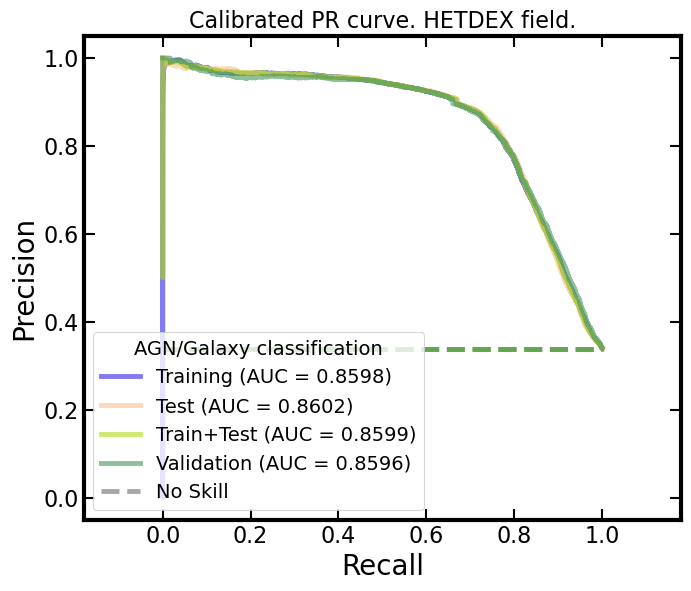

In [84]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [85]:
fscore_train_cal      = (2 * prec_train_cal      * recall_train_cal)      / (prec_train_cal      + recall_train_cal)
fscore_test_cal       = (2 * prec_test_cal       * recall_test_cal)       / (prec_test_cal       + recall_test_cal)
fscore_train_test_cal = (2 * prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal + recall_train_test_cal)
fscore_validation_cal = (2 * prec_validation_cal * recall_validation_cal) / (prec_validation_cal + recall_validation_cal)

In [86]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [87]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training   = 1.00000
Optimal threshold from Precision-Recall curve for test       = 0.34338
Optimal threshold from Precision-Recall curve for train+test = 0.34611
Optimal threshold from Precision-Recall curve for validation = 0.31758


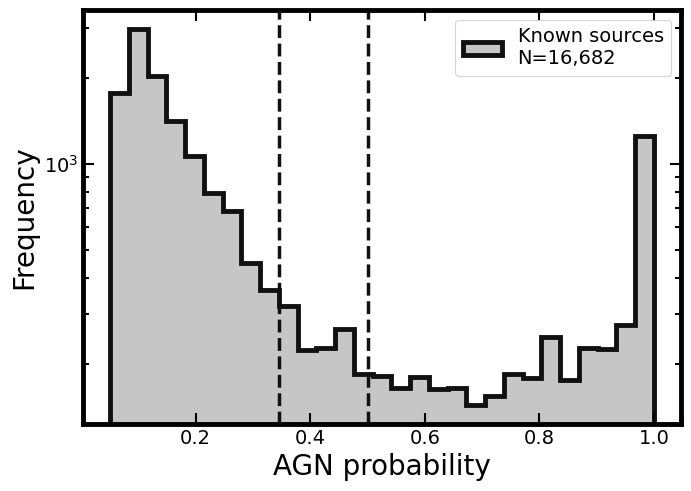

In [88]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(pred_cal_prob_validation)
max_score  = np.nanmax(pred_cal_prob_validation)
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(pred_cal_prob_validation)

ax1.hist(pred_cal_prob_validation, bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_train_test_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_AGN_cal_scores_known.pdf', bbox_inches='tight')
plt.show()

In [92]:
if save_model_flag:
    dump(calibrated_final_AGN_clf, gv.models_path + gv.cal_AGN_gal_model)

In [90]:
# if load_model_flag:
#     clf_test = load( gv.models_path + gv.cal_AGN_gal_model)

In [91]:
# clf_test.predict_proba(validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)])